In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import csv
import tensorflow as tf
import matplotlib.image as mpimg
from tqdm import tqdm

In [2]:
VIDEO_PATH = 'GOPR0485.MP4'
TEST_IMG_PATH = './test2/test_IMG/'
DRIVE_TEST_CSV_PATH = './test2/driving_test.csv'
TEST_PREDICT_PATH = './test2/test_predict/'

WEIGHTS = 'model-weights-Vtest.h5'
EVAL_SAMPLE_SIZE = 100 # Number of samples to evaluate to compute MSE

In [3]:
### Preprocessing helpers
def preprocess_image(image):
#     image_cropped = image[100:440, :-90] # -> (380, 550, 3)
#     image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    image = cv2.resize(image, (220, 66), interpolation = cv2.INTER_AREA)
    return image


def preprocess_image_valid_from_path(image_path, speed):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img)
    return img, speed


In [4]:
from model import nvidia_model
from opticalHelpers import opticalFlowDenseDim3
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
# tf.python.control_flow_ops = tf
N_img_height = 66
N_img_width = 220
N_img_channels = 3

Using TensorFlow backend.


In [5]:
model = nvidia_model()
model.load_weights(WEIGHTS)

C:\Users\Yair\Code\speedChallenge\test_suite\model.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), name="conv1", strides=(2, 2), padding="valid", kernel_initializer="he_normal")`
  name = 'conv1'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), name="conv2", strides=(2, 2), padding="valid", kernel_initializer="he_normal")`
  name = 'conv2'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), name="conv3", strides=(2, 2), padding="valid", kernel_initializer="he_normal")`
  name = 'conv3'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv4", strides=(1, 1), padding="valid", kernel_initializer="he_normal")`
  name = 'conv4'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:53

In [6]:
cap = cv2.VideoCapture(VIDEO_PATH)
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

# with open(DRIVE_TEST_CSV_PATH, 'w') as csvfile:
#     fieldnames = ['image_path', 'time', 'speed']
#     writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
#     writer.writeheader()

#     for _ in range(int(n_frames/3)):
#         time = cap.get(cv2.CAP_PROP_POS_MSEC)
#         success, image = cap.read()
#         if success:
#             image_path = os.path.join(TEST_IMG_PATH, str(time) + '.jpg')

#             # save image to IMG folder
#             cv2.imwrite(image_path, image)

#             # write row to driving.csv
#             writer.writerow({'image_path': image_path, 
#                      'time':time,
#                      'speed':np.nan,
#                     })
cap.release()

In [48]:
data = pd.read_csv(DRIVE_TEST_CSV_PATH)
data.time = data.time/1000 # convert from ms to seconds (for the following conditionals)
predictions = []
for idx in tqdm(range(1, len(data) - 1)):
    row_now = data.iloc[[idx]].reset_index()
    row_prev = data.iloc[[idx - 1]].reset_index()
    row_next = data.iloc[[idx + 1]].reset_index()

    # Find the 3 respective times to determine frame order (current -> next)

    time_now = row_now['time'].values[0]
    time_prev = row_prev['time'].values[0]
    time_next = row_next['time'].values[0]

    if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
        # in this case row_prev is x1 and row_now is x2
        row1 = row_prev
        row2 = row_now

    elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
        # in this case row_now is x1 and row_next is x2
        row1 = row_now
        row2 = row_next

    x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0], row1['speed'].values[0])
    x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0], row2['speed'].values[0])

    img_diff = opticalFlowDenseDim3(x1, x2)
    img_diff_reshaped = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
    predictions.append(model.predict(img_diff_reshaped)[0][0])
#     error = abs(prediction - y2)


100%|██████████████████████████████████████████████████████████████████████████████| 6615/6615 [23:00<00:00,  4.82it/s]


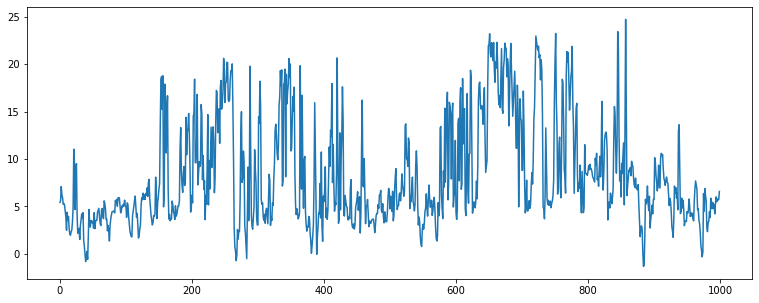

In [60]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(predictions[1000:2000])

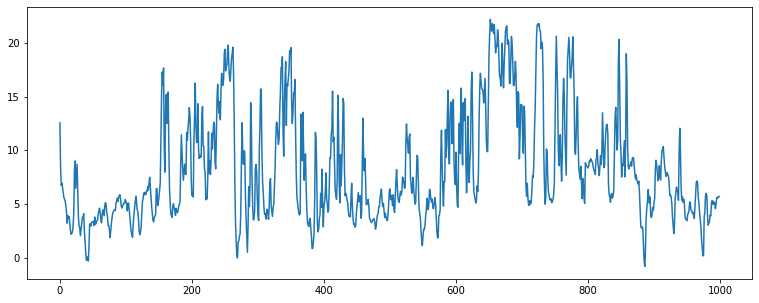

In [62]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
smooth_model = SimpleExpSmoothing(predictions)
fitted_smooth_model = smooth_model.fit()
smoothed_preds = fitted_smooth_model.predict(start=0,end=len(predictions)-1)

plt.figure(figsize=(13,5))
plt.plot(smoothed_preds[1000:2000])

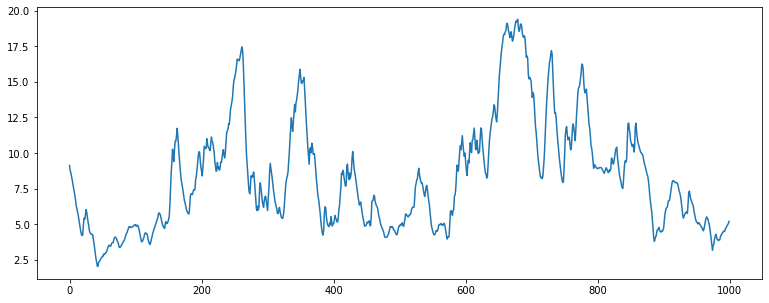

In [79]:
smoothed_preds = predictions[:]
for idx in range(1, len(predictions)):
    smoothed_preds[idx] = 0.1 * smoothed_preds[idx] + 0.9 * smoothed_preds[idx-1]
plt.figure(figsize=(13,5))
plt.plot(smoothed_preds[1000:2000])

In [80]:
COUNT = 0
for idx,pred in enumerate(smoothed_preds):
    predict_path = os.path.join(TEST_PREDICT_PATH, str(idx+1) + '.jpg')
                                   
    # overwrite the prediction of y2 onto image x2
    # save overwritten image x2 to new directory ./data/predict

                                   
    # Make a copy
    img = cv2.imread(data.image_path[idx+1])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x2_copy = np.copy(img)
    
    # to write new image via openCV
    offset = 100
    font = cv2.FONT_HERSHEY_SIMPLEX
#     x2_copy = cv2.resize(x2_copy, (640, 480), interpolation = cv2.INTER_AREA)
    cv2.putText(x2_copy, str(3.6*pred)[:5] + ' km/h',(50,offset), font, 2,(0,0,0),2,cv2.LINE_AA)
#     cv2.putText(x2_copy,'pred: ' + str(prediction[0][0])[:5],(5,offset), font, 1,(0,0,0),1,cv2.LINE_AA)
#     cv2.putText(x2_copy,'truth: ' + str(y2)[:5],(5,offset * 2), font, 1,(0,20,255),1,cv2.LINE_AA)
#     cv2.putText(x2_copy, 'error: ' + str(error[0][0])[:5], (5, offset*3),font, 1, (255, 0, 0),1, cv2.LINE_AA)
    
    # convert back to BGR for writing
    x2_copy = cv2.cvtColor(x2_copy, cv2.COLOR_RGB2BGR)
    COUNT += 1
    cv2.imwrite(predict_path, x2_copy)
    
print('done creating test predictions')

done creating test predictions


In [81]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
import glob
import os

images = [TEST_PREDICT_PATH + str(i+1) + '.jpg' for i in range(0, COUNT - 1)]
clip = ImageSequenceClip(images, fps=fps)
clip.write_videofile("movie-vTest.mp4", fps = fps)
print('done creating video')

[MoviePy] >>>> Building video movie-vTest.mp4
[MoviePy] Writing video movie-vTest.mp4



  1%|█                                                                               | 87/6614 [00:13<23:43,  4.59it/s]


  2%|█▉                                                                             | 157/6614 [00:26<19:52,  5.41it/s]


  3%|██▋                                                                            | 225/6614 [00:40<23:34,  4.52it/s]


  4%|███▌                                                                           | 295/6614 [00:56<16:59,  6.20it/s]


  5%|████▎                                                                          | 363/6614 [01:10<21:24,  4.87it/s]


  7%|█████▏                                                                         | 431/6614 [01:24<24:56,  4.13it/s]


  8%|█████▉                                                                         | 499/6614 [01:37<23:04,  4.42it/s]


  9%|██████▊                                                                        | 570/6614 [01:51<19:42,  5.11it/s]


 10%|███████▋                                                                       | 642/6614 [02:05<14:48,  6.72it/s]


 11%|████████▌                                                                      | 712/6614 [02:19<19:54,  4.94it/s]


 12%|█████████▍                                                                     | 794/6614 [02:34<19:12,  5.05it/s]


 13%|██████████▎                                                                    | 865/6614 [02:47<20:37,  4.65it/s]


 14%|███████████▎                                                                   | 946/6614 [03:03<19:46,  4.78it/s]


 16%|████████████▏                                                                 | 1029/6614 [03:20<17:50,  5.22it/s]


 17%|████████████▉                                                                 | 1099/6614 [03:34<23:30,  3.91it/s]


 18%|█████████████▊                                                                | 1171/6614 [03:50<19:11,  4.73it/s]


 19%|██████████████▋                                                               | 1245/6614 [04:06<15:50,  5.65it/s]


 20%|███████████████▍                                                              | 1313/6614 [04:21<16:48,  5.26it/s]


 21%|████████████████▎                                                             | 1381/6614 [04:35<14:46,  5.91it/s]


 22%|█████████████████                                                             | 1449/6614 [04:49<20:15,  4.25it/s]


 23%|█████████████████▉                                                            | 1517/6614 [05:03<16:19,  5.20it/s]


 24%|██████████████████▋                                                           | 1585/6614 [05:18<22:08,  3.79it/s]


 25%|███████████████████▌                                                          | 1654/6614 [05:33<23:16,  3.55it/s]


 26%|████████████████████▎                                                         | 1722/6614 [05:48<28:01,  2.91it/s]


 27%|█████████████████████                                                         | 1790/6614 [06:03<12:40,  6.34it/s]


 28%|█████████████████████▉                                                        | 1858/6614 [06:16<20:32,  3.86it/s]


 29%|██████████████████████▋                                                       | 1927/6614 [06:30<17:27,  4.47it/s]


 30%|███████████████████████▌                                                      | 1995/6614 [06:43<14:23,  5.35it/s]


 31%|████████████████████████▎                                                     | 2064/6614 [06:58<13:23,  5.67it/s]


 32%|█████████████████████████▏                                                    | 2132/6614 [07:12<12:15,  6.09it/s]


 33%|█████████████████████████▉                                                    | 2202/6614 [07:24<10:53,  6.75it/s]


 34%|██████████████████████████▊                                                   | 2275/6614 [07:37<13:48,  5.24it/s]


 35%|███████████████████████████▋                                                  | 2345/6614 [07:50<14:19,  4.97it/s]


 36%|████████████████████████████▍                                                 | 2413/6614 [08:01<11:49,  5.92it/s]


 38%|█████████████████████████████▎                                                | 2486/6614 [08:14<11:55,  5.77it/s]


 39%|██████████████████████████████▏                                               | 2558/6614 [08:27<12:52,  5.25it/s]


 40%|███████████████████████████████                                               | 2634/6614 [08:40<11:43,  5.66it/s]


 41%|███████████████████████████████▉                                              | 2710/6614 [08:54<15:51,  4.10it/s]


 42%|████████████████████████████████▊                                             | 2780/6614 [09:08<14:56,  4.28it/s]


 43%|█████████████████████████████████▌                                            | 2850/6614 [09:22<11:44,  5.34it/s]


 44%|██████████████████████████████████▌                                           | 2926/6614 [09:36<09:33,  6.43it/s]


 45%|███████████████████████████████████▍                                          | 3008/6614 [09:49<11:21,  5.29it/s]


 47%|████████████████████████████████████▍                                         | 3095/6614 [10:04<12:15,  4.79it/s]


 48%|█████████████████████████████████████▍                                        | 3174/6614 [10:19<12:57,  4.42it/s]


 49%|██████████████████████████████████████▎                                       | 3248/6614 [10:34<12:08,  4.62it/s]


 50%|███████████████████████████████████████▎                                      | 3332/6614 [10:49<08:51,  6.18it/s]


 52%|████████████████████████████████████████▏                                     | 3408/6614 [11:02<09:27,  5.65it/s]


 53%|█████████████████████████████████████████▏                                    | 3492/6614 [11:17<07:48,  6.66it/s]


 54%|██████████████████████████████████████████▏                                   | 3575/6614 [11:33<08:24,  6.02it/s]


 55%|███████████████████████████████████████████                                   | 3654/6614 [11:46<09:51,  5.01it/s]


 56%|████████████████████████████████████████████                                  | 3735/6614 [12:00<07:04,  6.78it/s]


 58%|█████████████████████████████████████████████▌                                | 3860/6614 [12:14<05:14,  8.74it/s]


 60%|██████████████████████████████████████████████▋                               | 3954/6614 [12:27<06:03,  7.32it/s]


 61%|███████████████████████████████████████████████▉                              | 4064/6614 [12:41<04:59,  8.51it/s]


 63%|█████████████████████████████████████████████████▏                            | 4172/6614 [12:54<07:03,  5.76it/s]


 65%|██████████████████████████████████████████████████▍                           | 4276/6614 [13:06<05:04,  7.69it/s]


 66%|███████████████████████████████████████████████████▋                          | 4380/6614 [13:19<05:43,  6.49it/s]


 68%|████████████████████████████████████████████████████▉                         | 4487/6614 [13:31<03:47,  9.34it/s]


 70%|██████████████████████████████████████████████████████▏                       | 4598/6614 [13:45<04:21,  7.71it/s]


 71%|███████████████████████████████████████████████████████▍                      | 4701/6614 [13:58<05:20,  5.96it/s]


 73%|████████████████████████████████████████████████████████▋                     | 4808/6614 [14:11<04:01,  7.47it/s]


 74%|██████████████████████████████████████████████████████████                    | 4923/6614 [14:24<03:02,  9.28it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 5021/6614 [14:36<03:17,  8.05it/s]


 77%|████████████████████████████████████████████████████████████▎                 | 5112/6614 [14:47<03:29,  7.17it/s]


 79%|█████████████████████████████████████████████████████████████▋                | 5226/6614 [15:01<03:29,  6.61it/s]


 81%|██████████████████████████████████████████████████████████████▉               | 5342/6614 [15:15<02:23,  8.89it/s]


 82%|████████████████████████████████████████████████████████████████▎             | 5449/6614 [15:28<02:21,  8.22it/s]


 84%|█████████████████████████████████████████████████████████████████▌            | 5564/6614 [15:41<01:50,  9.54it/s]


 86%|██████████████████████████████████████████████████████████████████▉           | 5680/6614 [15:54<02:13,  7.01it/s]


 88%|████████████████████████████████████████████████████████████████████▎         | 5788/6614 [16:07<01:54,  7.23it/s]


 89%|█████████████████████████████████████████████████████████████████████▍        | 5893/6614 [16:20<01:30,  7.98it/s]


 91%|██████████████████████████████████████████████████████████████████████▊       | 6003/6614 [16:33<01:11,  8.55it/s]


 92%|████████████████████████████████████████████████████████████████████████      | 6115/6614 [16:47<01:00,  8.20it/s]


 94%|█████████████████████████████████████████████████████████████████████████▎    | 6216/6614 [16:59<00:51,  7.76it/s]


 96%|██████████████████████████████████████████████████████████████████████████▌   | 6320/6614 [17:12<00:39,  7.52it/s]


 97%|███████████████████████████████████████████████████████████████████████████▋  | 6422/6614 [17:24<00:24,  7.76it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▏| 6548/6614 [17:39<00:06,  9.57it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 6614/6614 [17:47<00:00,  6.20it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie-vTest.mp4 

done creating video


In [83]:
import pickle

with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
with open('predictions.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [85]:
b == predictions

True